In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm

In [2]:
from networks.vae import ConvVAE

In [3]:
# Load observation and action files
file_paths_obs = [f'data/train_observations_batch_{i}.npy' for i in range(8)]
file_paths_actions = [f'data/train_actions_batch_{i}.npy' for i in range(8)]

data_obs = [np.load(file) for file in file_paths_obs]
data_actions = [np.load(file) for file in file_paths_actions]

# Verify shapes
print(f'Observation data shape: {data_obs[0].shape}')
print(f'Action data shape: {data_actions[0].shape}')

Observation data shape: (512, 33, 4, 3, 64, 64)
Action data shape: (512, 33, 4, 2)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = ConvVAE(3, 32)
vae.load_state_dict(torch.load('saved_models/vae/vae_model_32.pth'))
vae.eval()

ConvVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=4096, out_features=32, bias=True)
    (fc_logvar): Linear(in_features=4096, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (fc_decode): Linear(in_features=32, out_features=4096, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [5]:
def encode_single_batch(vae, obs_batch, device):
    # Reshape to (512*4*33, 3, 64, 64)
    vae.to(device)
    flat_obs = obs_batch.reshape(-1, 3, 64, 64)

    # Create DataLoader for batch processing
    data_tensor_obs = torch.tensor(flat_obs, dtype=torch.float32)
    batch_size = 32
    dataset_obs = TensorDataset(data_tensor_obs)
    data_loader_obs = DataLoader(dataset_obs, batch_size=batch_size, shuffle=False)

    latent_representations = []
    
    with torch.no_grad():
        for data in tqdm(data_loader_obs):
            obs_tensor = data[0].to(device)
            z = vae.encode(obs_tensor)
            latent_representations.append(z.cpu().numpy())
    
    latent_representations = np.concatenate(latent_representations, axis=0)
    # Reshape back to (512, 33, 4, latent_dim)
    latent_dim = latent_representations.shape[-1]
    latent_representations = latent_representations.reshape(512, 33, 4, latent_dim)
    return latent_representations

In [6]:
def encode_all_batches(vae, data_obs, device):
    all_latent_representations = []

    for obs_batch in data_obs:
        latent_representations = encode_single_batch(vae, obs_batch, device)
        all_latent_representations.append(latent_representations)

    # Concatenate all latent representations
    all_latent_representations = np.concatenate(all_latent_representations, axis=0)
    return all_latent_representations

In [7]:
# Encode all batches
all_latent_representations = encode_all_batches(vae, data_obs, device)

# Check the shape of the combined latent representations
print(f'All latent representations shape: {all_latent_representations.shape}')

100%|██████████| 2112/2112 [00:07<00:00, 288.18it/s]


All latent representations shape: (4096, 33, 4, 32)


In [8]:
all_actions = np.concatenate(data_actions, axis=0)
reshaped_actions = all_actions.transpose(0, 2, 1, 3).reshape(-1, 33, 2)

# Reshape the data to treat each agent in different areas as separate episodes
reshaped_latent = all_latent_representations.transpose(0, 2, 1, 3).reshape(-1, 33, 32)  # Shape: (16384, 33, 32)
# Create input sequences by taking the first 32 time steps
input_sequences = np.concatenate([reshaped_latent[:, :32, :], reshaped_actions[:, :32, :]], axis=-1)  # Shape: (16384, 32, 34)
# Create target sequences by taking the next 32 time steps
target_sequences = reshaped_latent[:, 1:33, :]  # Shape: (16384, 32, 32)

print("Input sequences shape:", input_sequences.shape)  # Expected: (16384, 32, 34)
print("Target sequences shape:", target_sequences.shape)  # Expected: (16384, 32, 32)

# Verify that the target sequences are the shifted input sequences
comparison = np.array_equal(input_sequences[:, 1:, :32], target_sequences[:, :-1, :])

if comparison:
    print("The target features are correctly offset by one time step compared to the input features.")
else:
    print("There is a discrepancy between the target features and the input features with the expected offset.")

Input sequences shape: (16384, 32, 34)
Target sequences shape: (16384, 32, 32)
The target features are correctly offset by one time step compared to the input features.


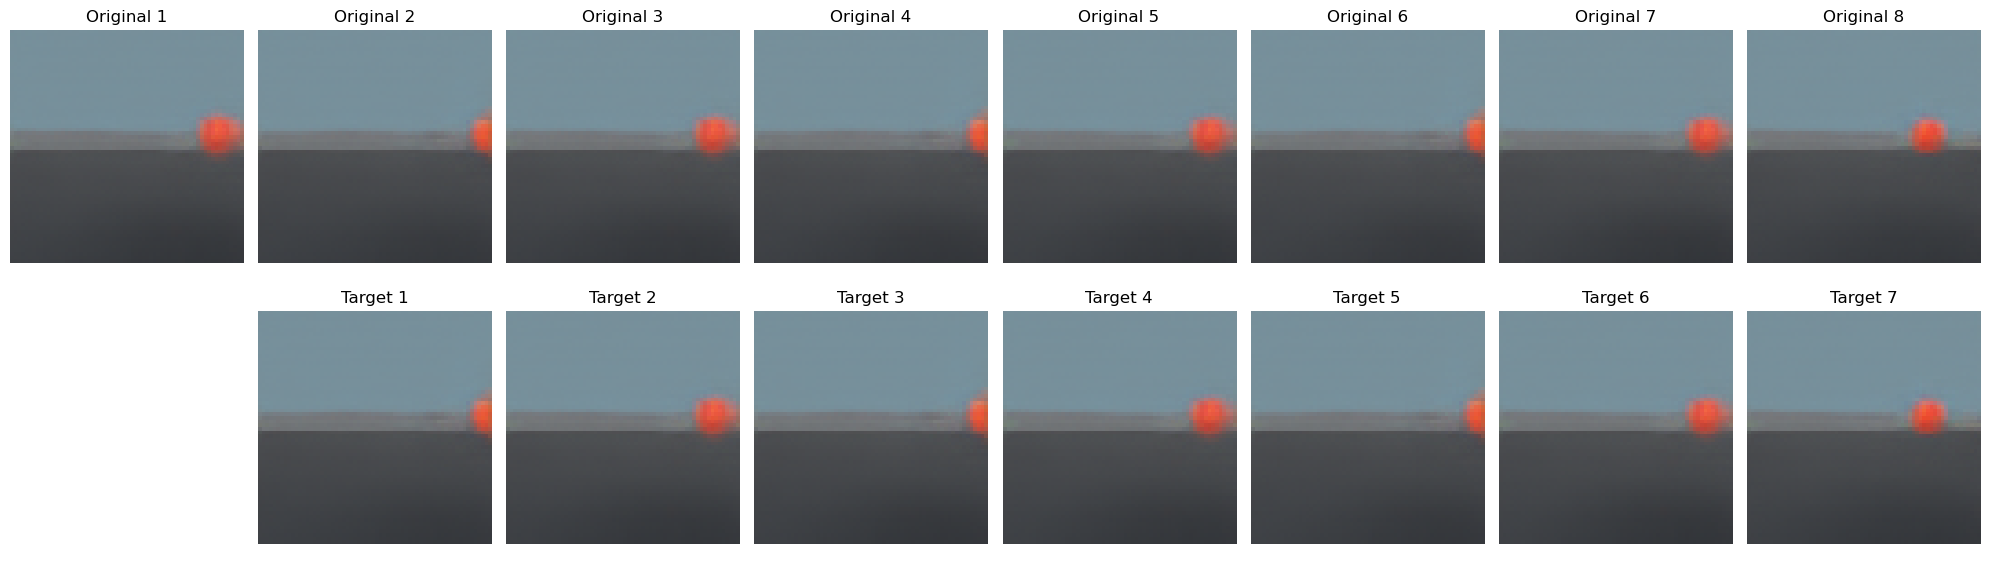

In [9]:
import matplotlib.pyplot as plt

random_episode_idx = np.random.randint(input_sequences.shape[0])
episode_input = input_sequences[random_episode_idx, :8, :32]
episode_target = target_sequences[random_episode_idx, :8]


z_input = torch.tensor(episode_input, dtype=torch.float32).to(device)
z_target = torch.tensor(episode_target, dtype=torch.float32).to(device)

with torch.no_grad():
    input_reconstructions = vae.decode(z_input)
    target_reconstructions = vae.decode(z_target)

input_reconstructions, target_reconstructions = input_reconstructions.cpu().numpy(), target_reconstructions.cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(20, 6))

for i in range(8):
    # Original images
    axes[0, i].imshow(input_reconstructions[i].transpose(1, 2, 0))
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')

    # Reconstructed images
    if i != 0:
        axes[1, i].imshow(target_reconstructions[i-1].transpose(1, 2, 0))
        axes[1, i].set_title(f'Target {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
class MDN(nn.Module):
    def __init__(self, input_dim, output_dim, n_mixtures):
        super(MDN, self).__init__()
        self.n_mixtures = n_mixtures
        self.output_dim = output_dim
        self.mu = nn.Linear(input_dim, output_dim * n_mixtures)
        self.sigma = nn.Linear(input_dim, output_dim * n_mixtures)
        self.pi = nn.Linear(input_dim, n_mixtures)

    def forward(self, x):
        mus = self.mu(x)
        sigmas = torch.exp(self.sigma(x))
        logpi = F.log_softmax(self.pi(x), dim=-1)

        return mus, sigmas, logpi


class MDNRNN(nn.Module):
    def __init__(self, latent_dim, action_dim, hidden_dim, n_mixtures=5):
        super(MDNRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.n_mixtures = n_mixtures
        self.rnn = nn.LSTM(latent_dim + action_dim, hidden_dim, batch_first=True)
        self.mdn = MDN(hidden_dim, latent_dim, n_mixtures)

    def forward(self, latent, action, hx=None, cx=None):
        batch_size, sequence_length = latent.size(0), latent.size(1)
        x = torch.cat([latent, action], dim=-1)
        if hx is None or cx is None:
            output, (hx_next, cx_next) = self.rnn(x)
        else:
            output, (hx_next, cx_next) = self.rnn(x, (hx, cx))
        mus, sigmas, logpi = self.mdn(output)
        mus = mus.view(batch_size, sequence_length, self.n_mixtures, self.latent_dim)
        sigmas = sigmas.view(batch_size, sequence_length, self.n_mixtures, self.latent_dim)
        logpi = logpi.view(batch_size, sequence_length, self.n_mixtures)
        
        return mus, sigmas, logpi, hx_next, cx_next

    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim)
    
def mdn_loss(mus, sigmas, logpi, targets):
    targets = targets.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(targets)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)
    log_prob = max_log_probs.squeeze() + torch.log(probs)
    
    return -torch.mean(log_prob)

In [11]:
def train_mdnrnn(model, data_loader, optimizer, device, n_epochs, save_path):
    model = model.to(device)

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        for inputs, targets in tqdm(data_loader):
            batch_inputs = inputs.to(device)
            batch_targets = targets.to(device)
           
            latent_obs = batch_inputs[:, :, :32]
            actions = batch_inputs[:, :, 32:]

            optimizer.zero_grad()

            mus, sigmas, logpi, _, _ = model(latent_obs, actions)
            
            loss = mdn_loss(mus, sigmas, logpi, batch_targets)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(data_loader)
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_train_loss:.4f}')

    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print(f'Trained model saved to {save_path}')

In [20]:
input_tensor = torch.tensor(input_sequences, dtype=torch.float32)
target_tensor = torch.tensor(target_sequences, dtype=torch.float32)

batch_size = 32
dataset = TensorDataset(input_tensor, target_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

hidden_dim = 128
mdnrnn = MDNRNN(latent_dim=32, action_dim=2, hidden_dim=hidden_dim)
optimizer = optim.Adam(mdnrnn.parameters(), lr=1e-3)

n_epochs = 10
save_path = f'saved_models/rnn/rnn_model_{hidden_dim}.pth'

train_mdnrnn(mdnrnn, data_loader, optimizer, device, n_epochs, save_path)

100%|██████████| 512/512 [00:04<00:00, 107.43it/s]


Epoch [1/10], Loss: -17.9767


100%|██████████| 512/512 [00:04<00:00, 113.38it/s]


Epoch [2/10], Loss: -34.6384


100%|██████████| 512/512 [00:04<00:00, 112.76it/s]


Epoch [3/10], Loss: -43.3463


100%|██████████| 512/512 [00:04<00:00, 111.88it/s]


Epoch [4/10], Loss: -45.7808


100%|██████████| 512/512 [00:04<00:00, 114.87it/s]


Epoch [5/10], Loss: -47.3536


100%|██████████| 512/512 [00:04<00:00, 111.10it/s]


Epoch [6/10], Loss: -48.8302


100%|██████████| 512/512 [00:04<00:00, 114.00it/s]


Epoch [7/10], Loss: -50.0812


100%|██████████| 512/512 [00:04<00:00, 114.79it/s]


Epoch [8/10], Loss: -50.9677


100%|██████████| 512/512 [00:04<00:00, 113.83it/s]


Epoch [9/10], Loss: -51.6823


100%|██████████| 512/512 [00:04<00:00, 112.70it/s]

Epoch [10/10], Loss: -52.3117
Trained model saved to saved_models/rnn_model_128.pth


In [21]:
def get_weighted_average_mean(mus, logpis):
    # Convert log(pi) to pi
    pis = np.exp(logpis)
    # Normalize the mixture weights
    pis_normalized = pis / np.sum(pis, axis=-1, keepdims=True)
    # Compute the weighted average of the means for each timestep
    weighted_average_mean = np.sum(mus * pis_normalized[..., np.newaxis], axis=1)
    return weighted_average_mean

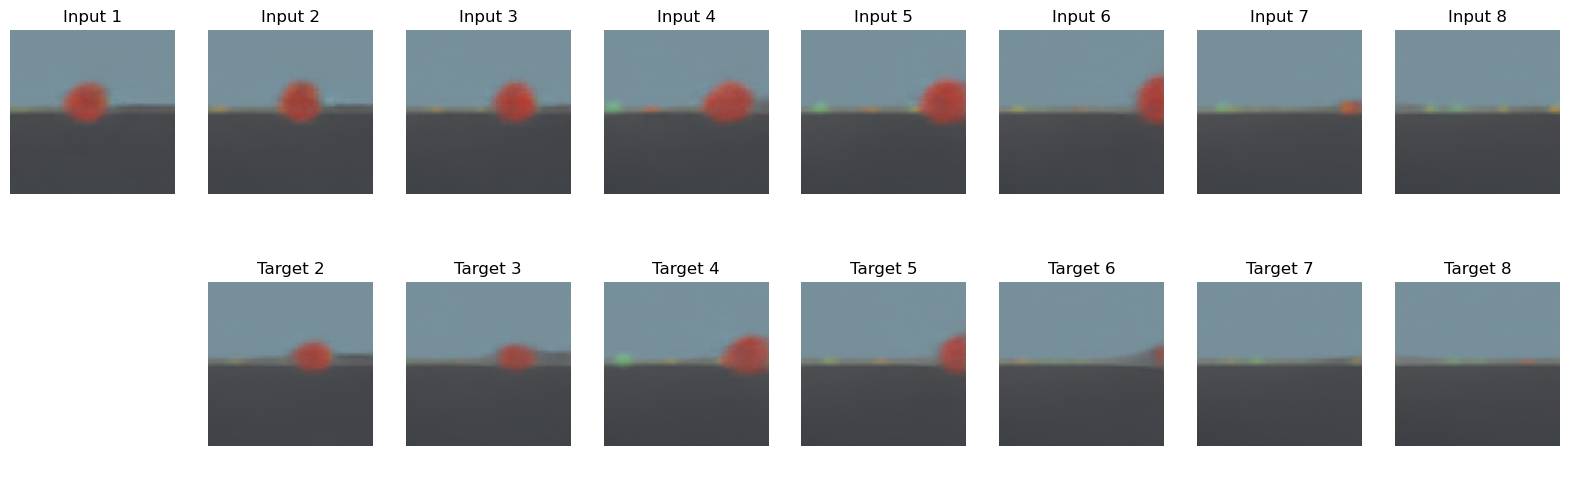

In [23]:
random_episode_idx = np.random.randint(input_sequences.shape[0])
episode_input = input_sequences[random_episode_idx, :8]

episode_z = episode_input[:, :32]
episode_a = episode_input[:, 32:]

z_tensor = torch.tensor(episode_z, dtype=torch.float32).to(device)
a_tensor = torch.tensor(episode_a, dtype=torch.float32).to(device)

pred_list = []

for i in range(8):
    z = z_tensor[i].unsqueeze(0).unsqueeze(1)
    a = a_tensor[i].unsqueeze(0).unsqueeze(1)
    with torch.no_grad():
        mus, _, logpis, _, _ = mdnrnn(z, a)
    pred = get_weighted_average_mean(mus.squeeze(0).cpu().numpy(), logpis.squeeze(0).cpu().numpy())
    pred_list.append(torch.tensor(pred, dtype=torch.float32))

z_pred_tensor = torch.concatenate(pred_list, dim=0).to(device) 

with torch.no_grad():
    input_reconstructions = vae.decode(z_tensor)
    pred_reconstructions = vae.decode(z_pred_tensor)

input_reconstructions, pred_reconstructions = input_reconstructions.cpu().numpy(), pred_reconstructions.cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(20, 6))

for i in range(8):
    # Input
    axes[0, i].imshow(input_reconstructions[i].transpose(1, 2, 0))
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')

    if i != 0:
        axes[1, i].imshow(pred_reconstructions[i].transpose(1, 2, 0))
        axes[1, i].set_title(f'Target {i+1}')
    axes[1, i].axis('off')